In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from azula.guidance import MMPSDenoiser
from azula.sample import LMSSampler, PCSampler
from einops import rearrange
from functools import partial
from omegaconf import OmegaConf
from pathlib import Path

from lpdm.data import field_preprocess, get_well_dataset, isotropic_power_spectrum
from lpdm.diffusion import get_denoiser
from lpdm.nn.autoencoder import AutoEncoder

_ = torch.manual_seed(0)

In [2]:
runpath = Path("/mnt/ceph/users/frozet/mpp-ldm/runs/pg5qkw4r_dit_large_False_adamw_0.0001_0.0_cosine_1")  # fmt: off
cfg = OmegaConf.load(runpath / "config.yaml")
device = "cuda"

## Data

In [3]:
testset = get_well_dataset(
    path=f"/mnt/ceph/users/polymathic/the_well/datasets/{cfg.dataset.physics}",
    split="test",
    steps=cfg.trajectory.length,
    dt_stride=cfg.trajectory.stride,
    include_filters=cfg.dataset.include_filters,
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

In [4]:
field_names = [name for group in testset.metadata.field_names.values() for name in group]

## Autoencoder

In [5]:
autoencoder = AutoEncoder(
    pix_channels=testset.metadata.n_fields,
    **cfg.ae,
)

autoencoder.load_state_dict(torch.load(runpath / "autoencoder/state.pth"))
autoencoder.cuda()
autoencoder.eval()

AutoEncoder(
  (encoder): Encoder(
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ResBlock(
          (block): Sequential(
            (0): GroupNorm(16, 64, eps=1e-05, affine=False)
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1-2): 2 x ResBlock(
          (block): Sequential(
            (0): GroupNorm(16, 128, eps=1e-05, affine=False)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )

## Denoiser

In [6]:
denoiser = get_denoiser(
    shape=(cfg.ae.lat_channels, cfg.trajectory.length, 64, 64),
    label_features=testset.metadata.n_constant_scalars,
    **cfg.denoiser,
)

denoiser.load_state_dict(torch.load(runpath / "state_ema.pth"))
denoiser.cuda()
denoiser.eval()

PreconditionedDenoiser(
  (backbone): FlattenWrapper(
    (wrappee): EmbeddingWrapper(
      (backbone): DiT(
        (patch): Rearrange('... C (L l) (H h) (W w) -> ... L H W (C l h w)', l=1, h=2, w=2)
        (unpatch): Rearrange('... L H W (C l h w) -> ... C (L l) (H h) (W w)', l=1, h=2, w=2)
        (in_proj): Linear(in_features=16, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=16, bias=True)
        (positional_embedding): Sequential(
          (0): Linear(in_features=3, out_features=1024, bias=True)
          (1): SiLU()
          (2): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (blocks): ModuleList(
          (0-15): 16 x DiTBlock(
            (norm): LayerNorm(dim=-1)
            (ada_zero): Sequential(
              (0): Linear(in_features=256, out_features=256, bias=True)
              (1): SiLU()
              (2): Linear(in_features=256, out_features=6144, bias=True)
              (3): Rearrange('... (n C

In [7]:
sum(p.numel() for p in denoiser.parameters())

228920080

## Evaluation

In [8]:
sampler = LMSSampler(denoiser, steps=64).to(device)

label = torch.tensor([1.13]).to(device)

z1 = sampler.init((1, 4 * cfg.trajectory.length * 64 * 64))
z0 = sampler(z1, label=label)
z0 = z0.reshape((1, 4, cfg.trajectory.length, 64, 64))

with torch.no_grad():
    x = torch.vmap(autoencoder.decode, in_dims=2, out_dims=2)(z0)

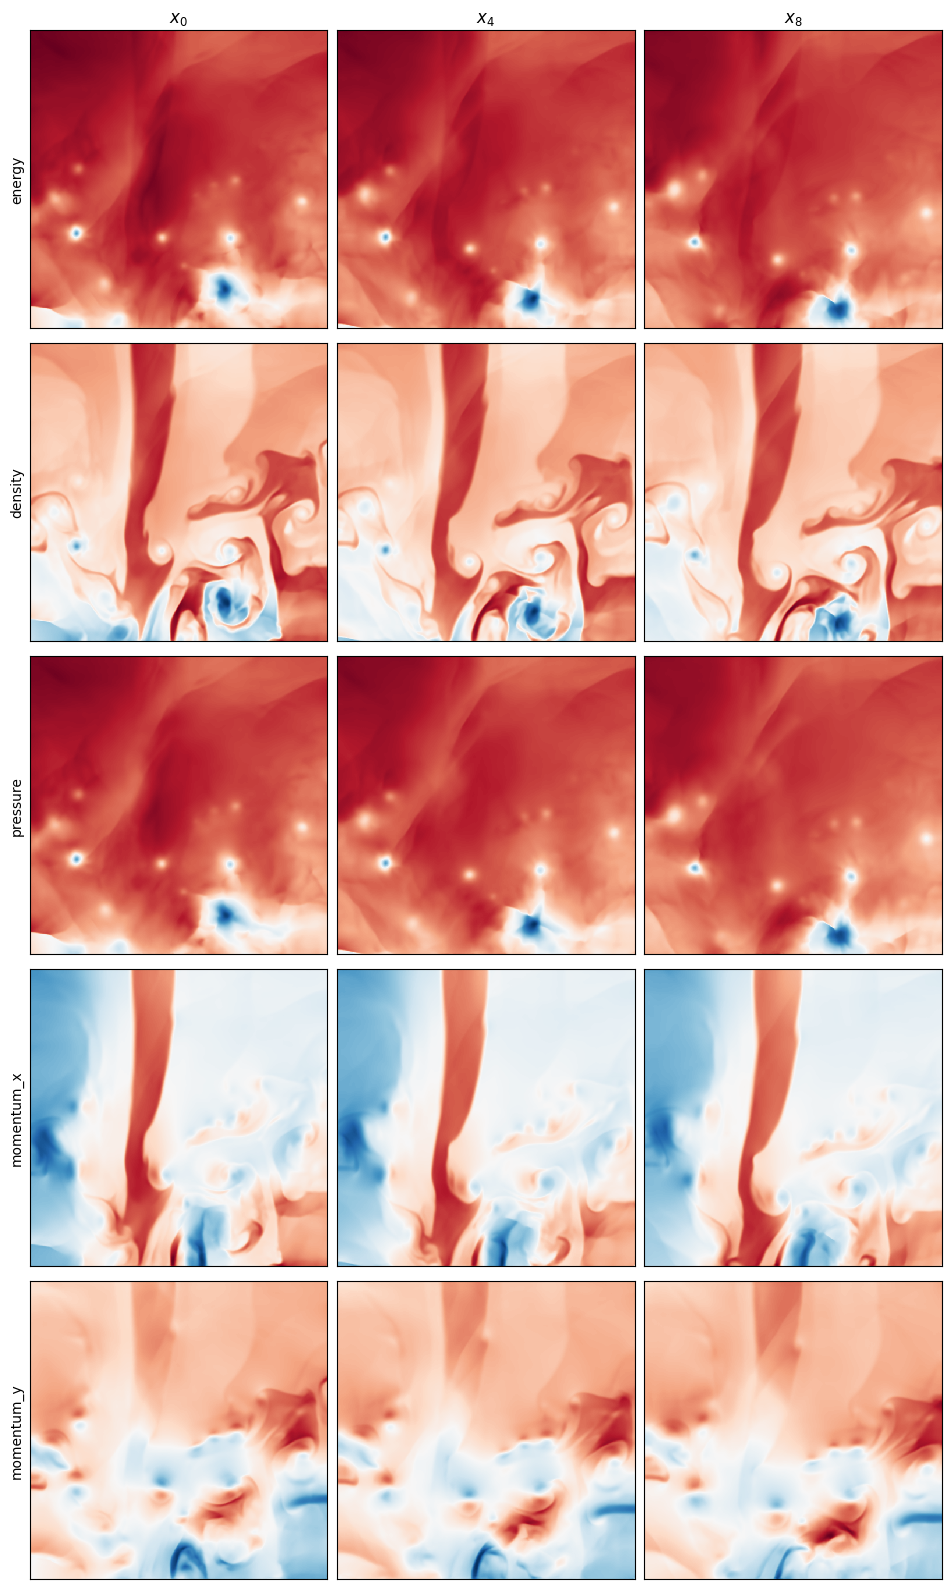

In [9]:
x = x.squeeze(0).cpu()

fig, axs = plt.subplots(5, cfg.trajectory.length, figsize=(3.2 * cfg.trajectory.length, 5 * 3.2))

for field in range(5):
    vmin = np.nanmin(x[field])
    vmax = np.nanmax(x[field])

    axs[field, 0].set_ylabel(f"{field_names[field]}")

    for i in range(cfg.trajectory.length):
        axs[field, i].imshow(
            x[field, i], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax
        )
        axs[field, i].set_xticks([])
        axs[field, i].set_yticks([])

        axs[0, i].set_title(rf"$x_{{{i * cfg.trajectory.stride}}}$")

plt.tight_layout()

## Condition

In [10]:
batch = testset[13]
x = batch["input_fields"]
x = x.to(device)
x = preprocess(x)
x = rearrange(x, "L H W C -> 1 C L H W")

label = batch["constant_scalars"].to(device)

with torch.no_grad():
    z = torch.vmap(autoencoder.encode, in_dims=2, out_dims=2)(x)

In [11]:
cond_denoiser = MMPSDenoiser(
    denoiser,
    A=lambda z: z.reshape((4, -1, 64, 64))[..., :, 0, :, :].reshape(1, -1),
    y=z[..., :, 0, :, :].reshape(1, -1),
    var_y=1e-6,
    iterations=3,
)

cond_sampler = PCSampler(cond_denoiser, steps=64, corrections=1, delta=0.1).to(device)

z1 = cond_sampler.init((1, 4 * cfg.trajectory.length * 64 * 64))
z0 = cond_sampler(z1, label=label)
z0 = z0.reshape((1, 4, cfg.trajectory.length, 64, 64))

with torch.no_grad():
    x_hat = torch.vmap(autoencoder.decode, in_dims=2, out_dims=2)(z0)

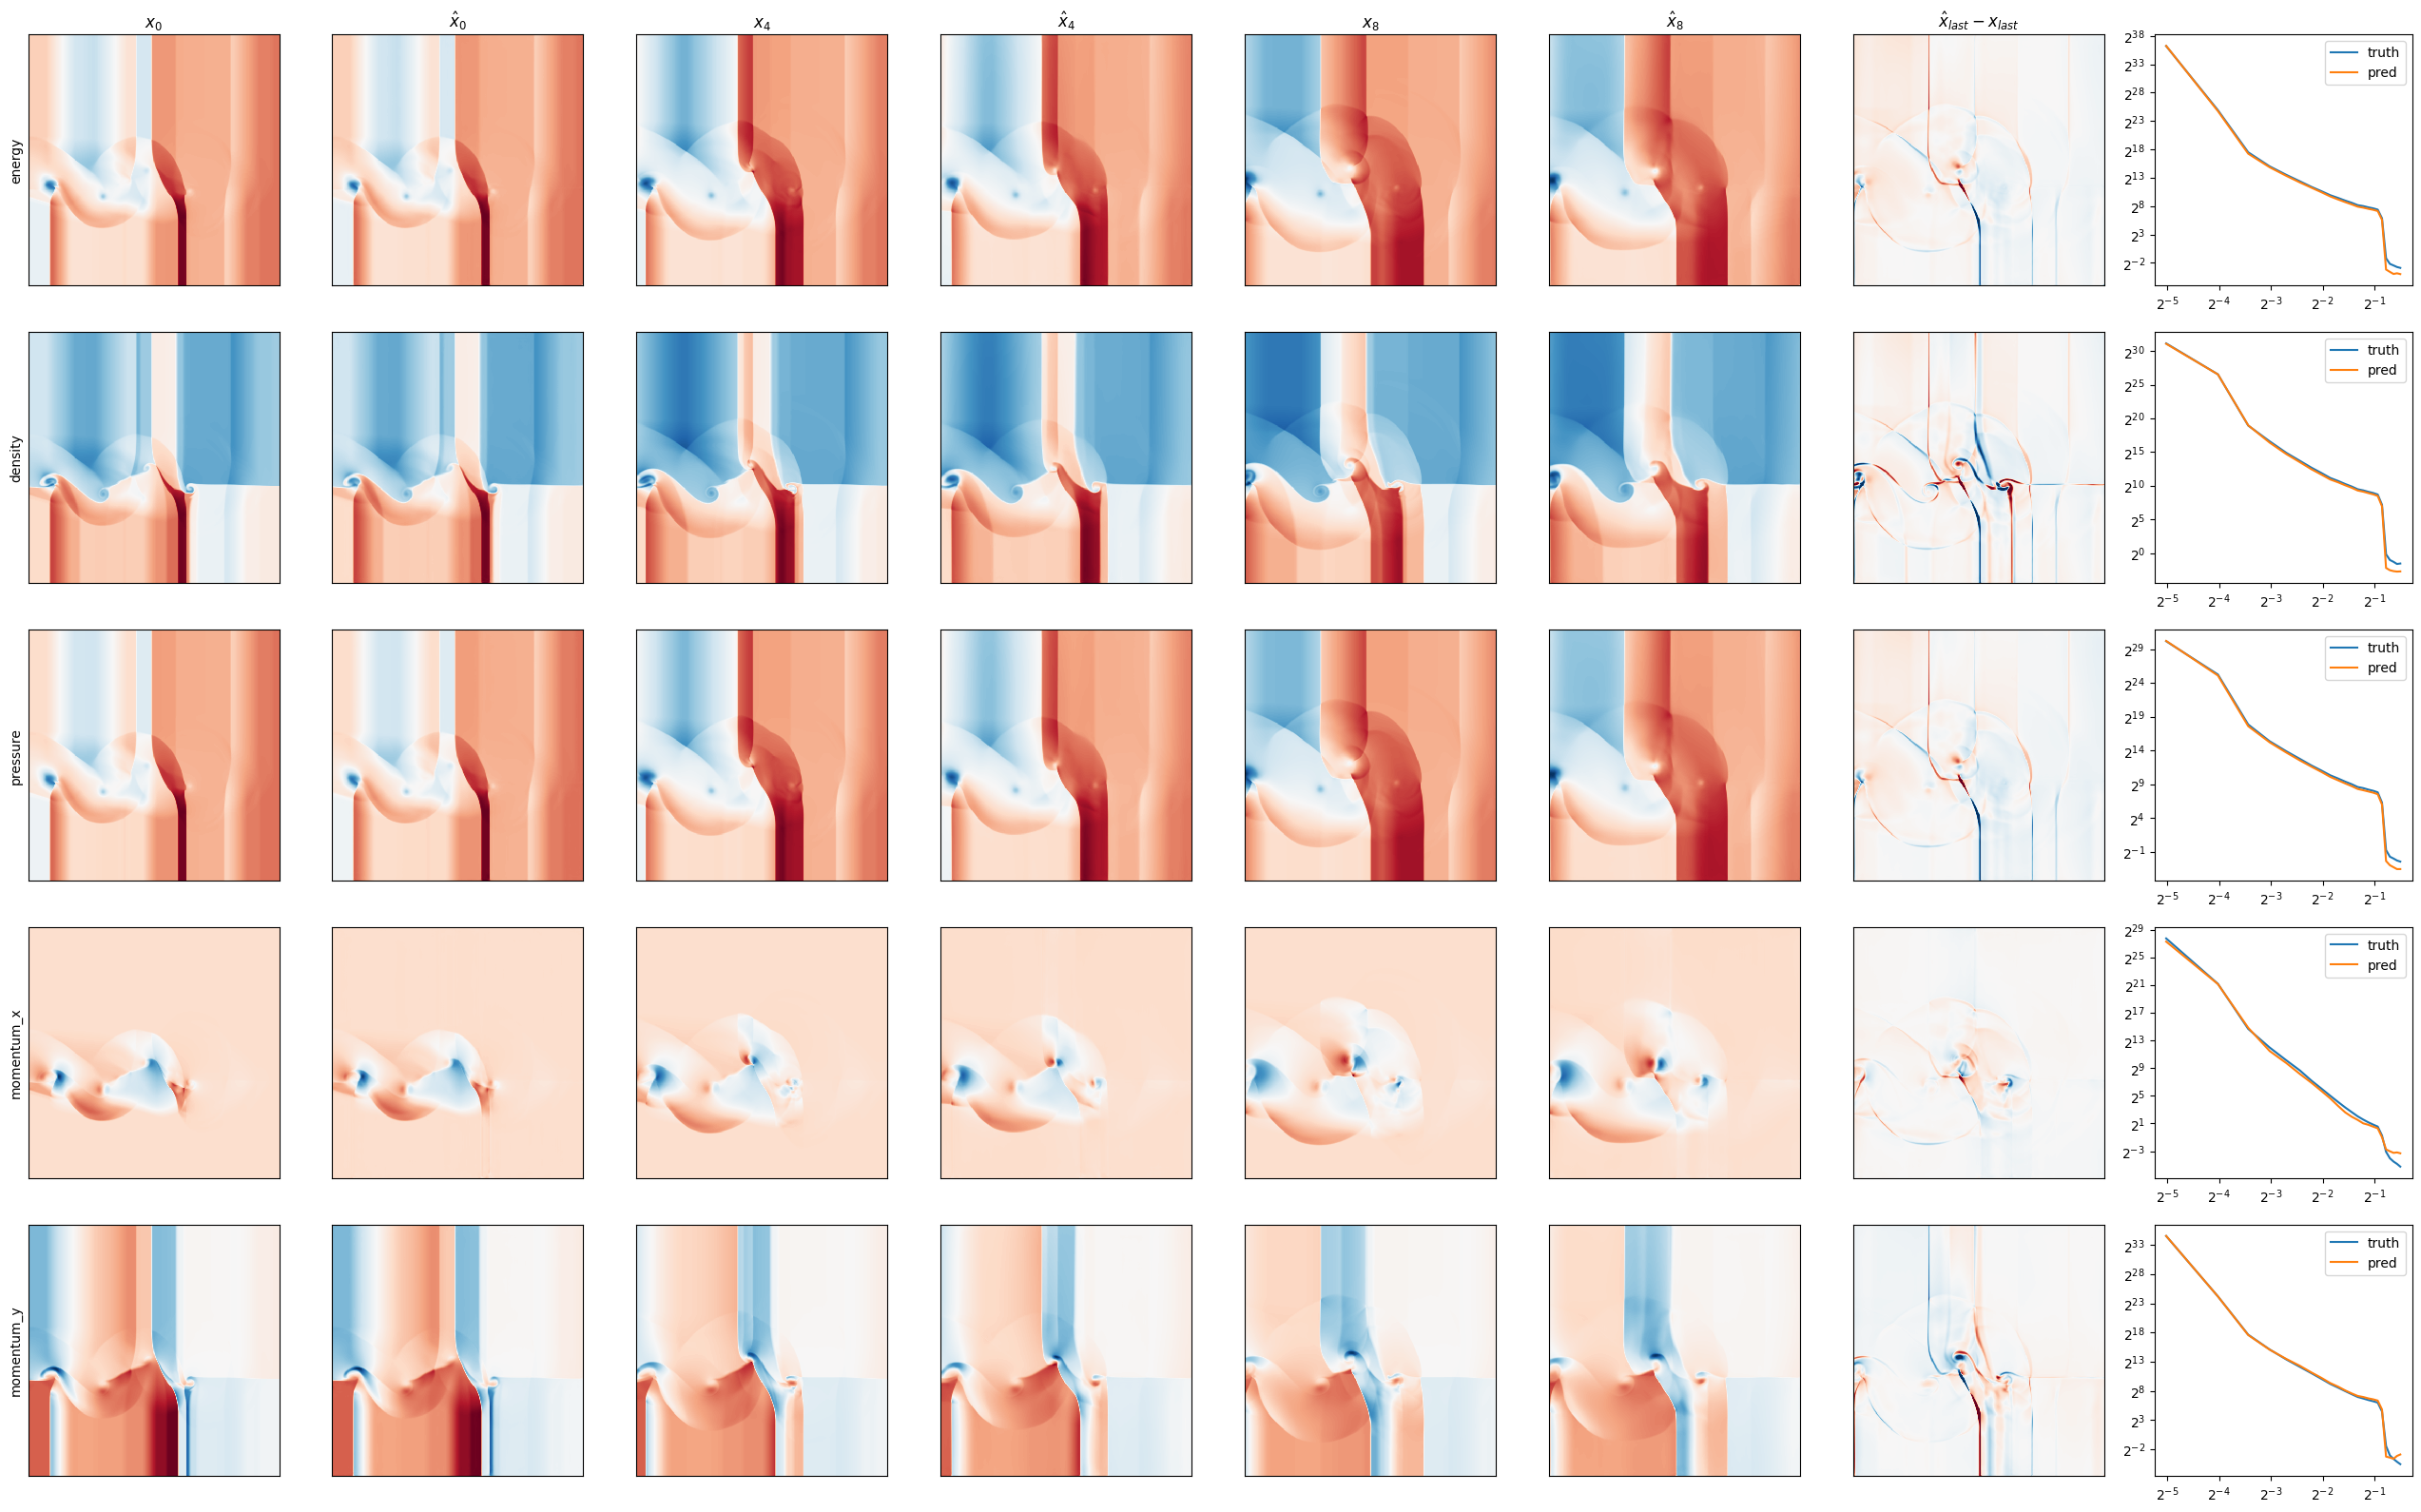

In [12]:
x = x.squeeze(0).cpu()
x_hat = x_hat.squeeze(0).cpu()

fig, axs = plt.subplots(
    5, 2 * cfg.trajectory.length + 2, figsize=(6.4 * cfg.trajectory.length + 6.4, 5 * 3.2)
)

for field in range(5):
    vmin = np.nanmin(x[field])
    vmax = np.nanmax(x[field])

    axs[field, 0].set_ylabel(f"{field_names[field]}")

    for i in range(cfg.trajectory.length):
        axs[field, 2 * i].imshow(
            x[field, i], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax
        )
        axs[field, 2 * i].set_xticks([])
        axs[field, 2 * i].set_yticks([])

        axs[field, 2 * i + 1].imshow(
            x_hat[field, i], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax
        )
        axs[field, 2 * i + 1].set_xticks([])
        axs[field, 2 * i + 1].set_yticks([])

        axs[0, 2 * i].set_title(rf"$x_{{{i * cfg.trajectory.stride}}}$")
        axs[0, 2 * i + 1].set_title(rf"$\hat{{x}}_{{{i * cfg.trajectory.stride}}}$")

    axs[field, -2].imshow(
        x_hat[field, -1] - x[field, -1], cmap="RdBu_r", interpolation="none", vmin=-1, vmax=1
    )
    axs[field, -2].set_xticks([])
    axs[field, -2].set_yticks([])

    axs[0, -2].set_title(r"$\hat{x}_{last} - x_{last}$")

    x_ps, x_edges = isotropic_power_spectrum(x[field, -1], spatial=2)
    x_hat_ps, x_hat_edges = isotropic_power_spectrum(x_hat[field, -1], spatial=2)

    axs[field, -1].loglog(x_edges[1:], x_ps, label="truth", base=2)
    axs[field, -1].loglog(x_hat_edges[1:], x_hat_ps, label="pred", base=2)
    axs[field, -1].legend()

plt.tight_layout()